In [3]:
# %matplotlib inline
# import sys
import h5py
import numpy as np
import pandas as pd
from PIL import ImageDraw, Image, ImageEnhance
from matplotlib import pyplot as plt
from pathlib import Path
import cv2

In [4]:
# sys.path.append('../../')
import fastmri
from fastmri.data import transforms as T 

In [5]:
# Import dataset
file_path = Path('multicoil_train')
file_list = list(file_path.glob('**/*.h5'))

In [6]:
# Choose .h5 file
file_name = file_list[2]
hf = h5py.File(file_name,'r')

In [7]:
annotatedSliceDataset = fastmri.data.mri_data.AnnotatedSliceDataset(file_path,"multicoil","knee","all", annotation_version="640500fb")

In [8]:
# Choose slice
slice_choice = 21
df = pd.DataFrame(annotatedSliceDataset.annotated_examples)
labels_for_slice = df[(df[0] == file_name) & (df[1] == slice_choice)][2].values.tolist()
labels_for_slice

[{'padding_left': 0,
  'padding_right': 370,
  'encoding_size': (640, 370, 1),
  'recon_size': (320, 320, 1),
  'annotation': {'fname': 'file1000638',
   'slice': 21,
   'study_level': 'No',
   'x': 235,
   'y': 137,
   'width': 13,
   'height': 6,
   'label': 'Meniscus Tear'}},
 {'padding_left': 0,
  'padding_right': 370,
  'encoding_size': (640, 370, 1),
  'recon_size': (320, 320, 1),
  'annotation': {'fname': 'file1000638',
   'slice': 21,
   'study_level': 'No',
   'x': 63,
   'y': 157,
   'width': 18,
   'height': 50,
   'label': 'Ligament - MCL Low-Mod Grade Sprain'}}]

Plot bounding box for annotation-change method
The bounding box need to move up one pixel to match

In [9]:
def plot_bounding_box(image, labels):
  plotted_image = ImageDraw.Draw(image)
  for label in labels:
    _, _, _, x0, y0, w, h, label_txt = label['annotation'].values()
    x1 = x0 + w
    y1 = y0 + h
    plotted_image.rectangle(((x0,y0), (x1,y1)), outline="white") 
    plotted_image.text((x0, max(0, y0 - 10)), label_txt, fill= "white")
  return np.array(image)

In [10]:
img_data = hf['reconstruction_rss'][:]
img_data.shape

(36, 320, 320)

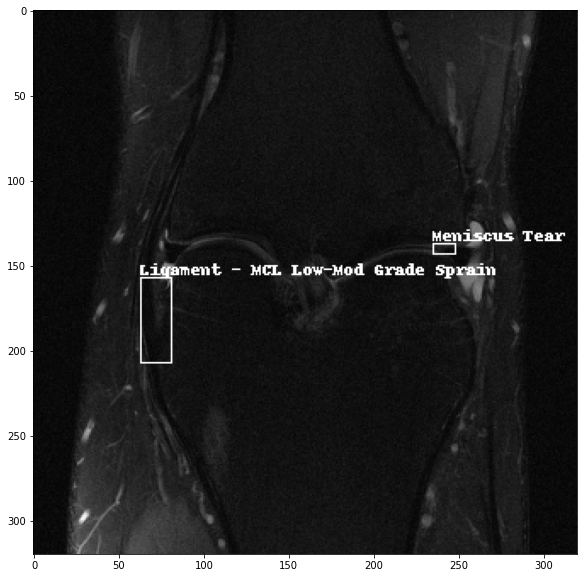

In [11]:
# Display an imageslice with annotations
arrimg = np.squeeze(img_data[slice_choice,:,:])
image_2d_scaled = (np.maximum(arrimg,0) / arrimg.max()) * 255.0
image_2d_scaled = Image.fromarray(np.uint8(image_2d_scaled))
annotated_img = plot_bounding_box(image_2d_scaled, labels_for_slice)
plt.figure(figsize = (10,10))
plt.imshow(annotated_img,'gray')
plt.show()

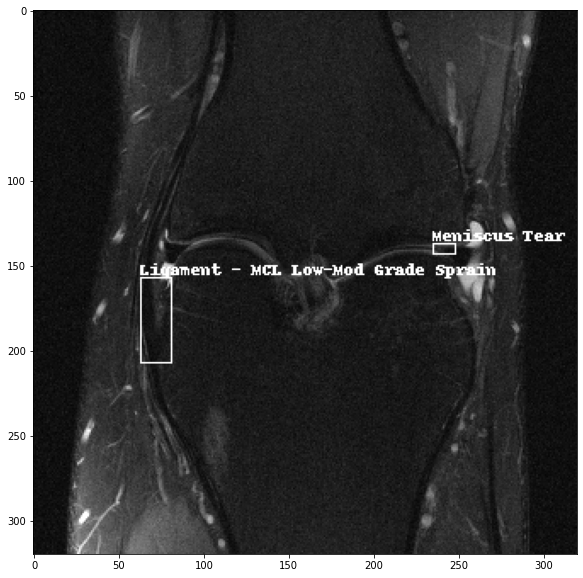

In [12]:
enhancer = ImageEnhance.Brightness(Image.fromarray(annotated_img))
annotated_img_enhanced = enhancer.enhance(1.5)
plt.figure(figsize = (10,10))
plt.imshow(annotated_img_enhanced,'gray')
plt.show()

In [13]:
# Zoomed image focusing on the tear
def plot_zoom_in_bounding_box(image, labels):
  plotted_image = ImageDraw.Draw(image)
  for label in labels:
    _, _, _, x0, y0, w, h, label_txt = label['annotation'].values()
    x1 = x0 + w
    y1 = y0 + h
    plotted_image.rectangle(((x0,y0), (x1,y1)), outline="white") 
    plotted_image.text((x0, max(0, y0 - 10)), label_txt, fill= "white")
    
  return np.array(image)

In [52]:
def cv2_clipped_zoom(img, zoom_factor=0):

    if zoom_factor == 0:
        return img

    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int32)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]
    
    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)
    
    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result

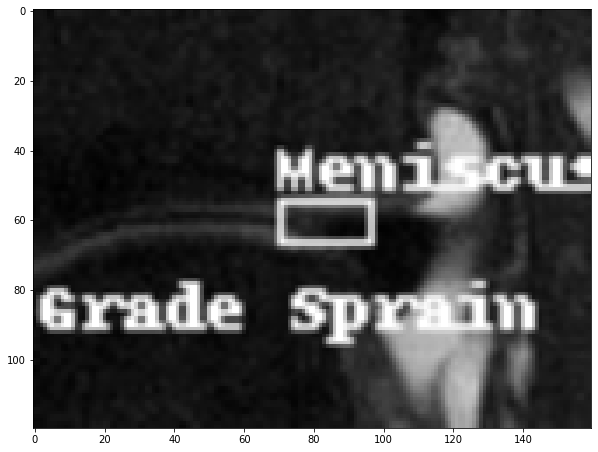

In [53]:
annotated_img_zoom_in = cv2_clipped_zoom(np.array(annotated_img_enhanced)[80:200,160:320],2)
plt.figure(figsize = (10,10))
plt.imshow(annotated_img_zoom_in,'gray')
plt.show()